<a href="https://colab.research.google.com/github/rushikram/javascript.rus/blob/main/Sentiment_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade xgboost



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")



In [3]:
from google.colab import files

uploaded = files.upload()


Saving Combined Data.csv.zip to Combined Data.csv (3).zip


In [4]:
df = pd.read_csv('Combined Data.csv.zip', index_col=0)


In [5]:
df.head()


,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
df.describe()


,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [8]:
df.isna().sum()


,0
statement,362
status,0


In [9]:
df.dropna(inplace = True)
df.isna().sum()


,0
statement,0
status,0


In [10]:
df.status.value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


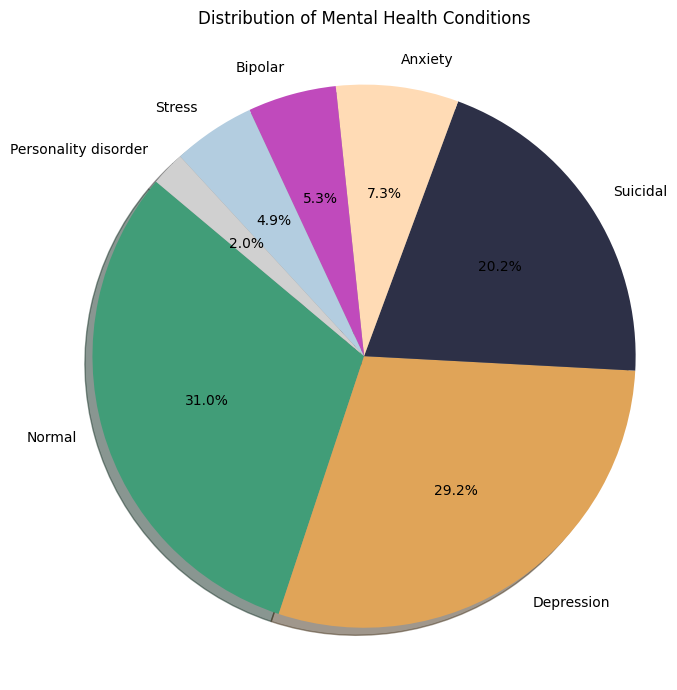

In [11]:
status_counts = df['status'].value_counts()
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')

plt.tight_layout()
plt.show()


In [12]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")


Status: Anxiety
Statement: Can't stop obsessing.. Any tips? Sorry if this is a little long, but I'm new here and desperately looking for some advice. Plus it kinda helps to get it all off my chest.. 

I've been struggling with health anxiety for a little while now, and although I keep kidding myself that I'm in control, I don't feel very in control. I can't stop the constant worrying and obsessing.

It all started just over a year ago, when I spent a week in hospital. I'm not going to go into detail as to why, as I don't want to trigger anyone else's anxiety... But it wasn't a great week.

Since then, I've been fine. I have ibs, which is unfortunate as the symptoms I get seem to really trigger my anxiety. But that's the most serious problem I have. A few other minor things, asthma, skin problems, but nothing unmanageable.

I noticed my anxiety levels shifting around a year on from my hospital stay. Think it must have just been on my mind, then I had a really bad ibs flare up that threw

In [13]:
  >>> import nltk
  >>> nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [14]:
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))


description = df[['num_of_characters', 'num_of_sentences']].describe()
print(description)


       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [15]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


In [16]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)

df['statement']=df['original_statement'].str.lower()
df.head()


,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


In [17]:
def remove_patterns(text):
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    text = re.sub(r'@\w+', '', text)

    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()


df['statement'] = df['statement'].apply(remove_patterns)
df.head()


,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [18]:
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()


,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


In [19]:
stemmer = PorterStemmer()


def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


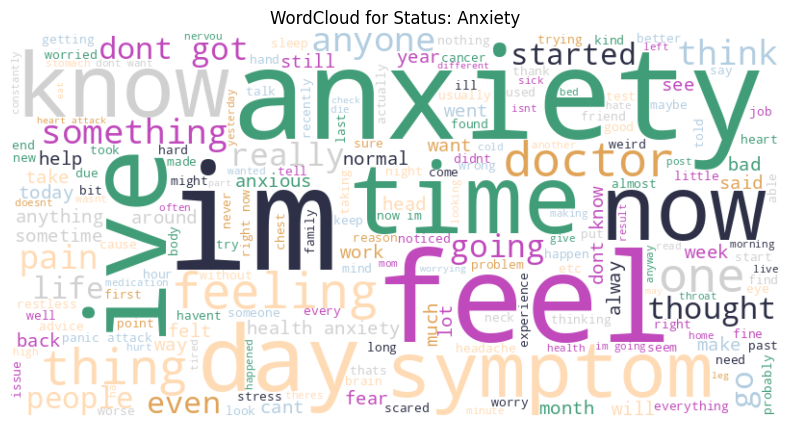

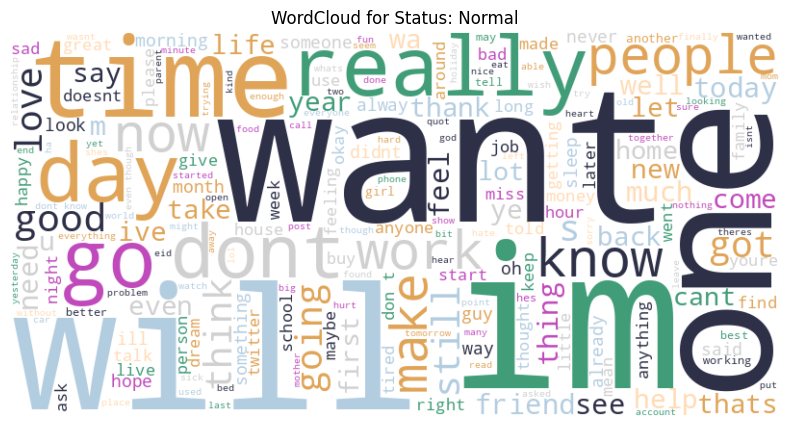

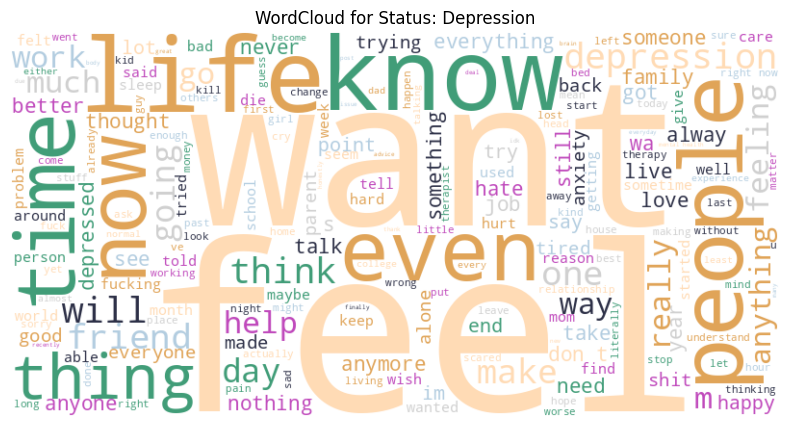

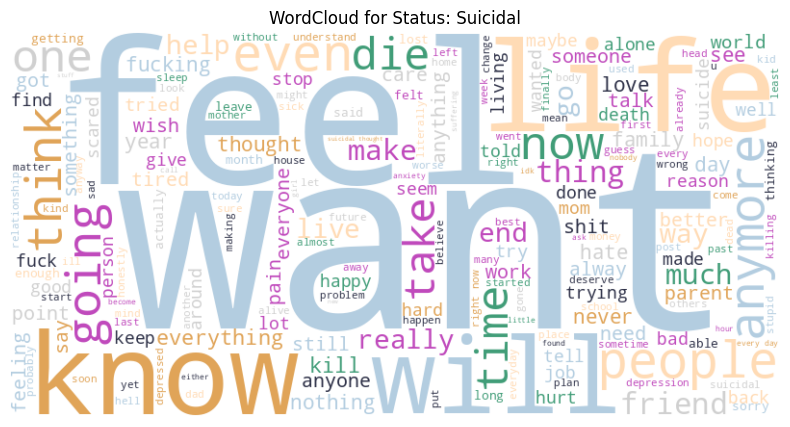

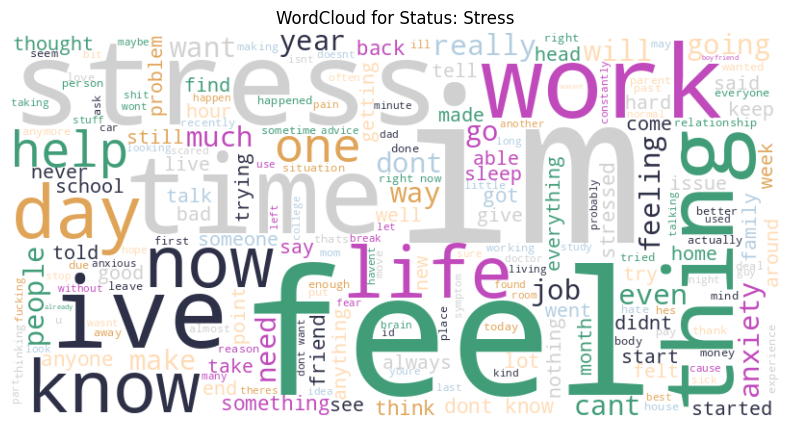

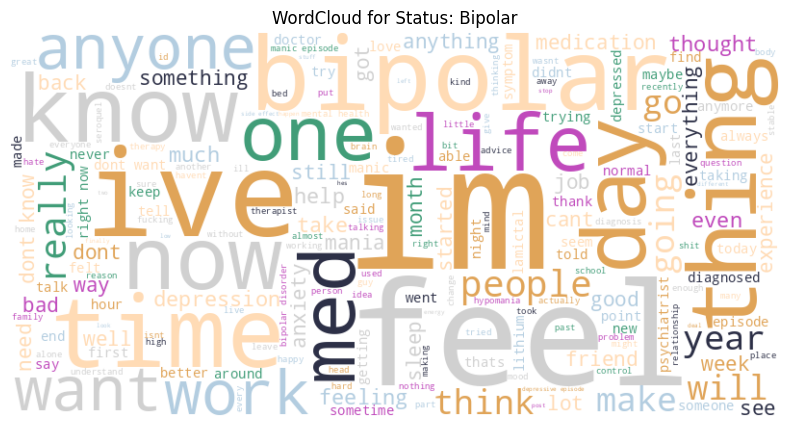

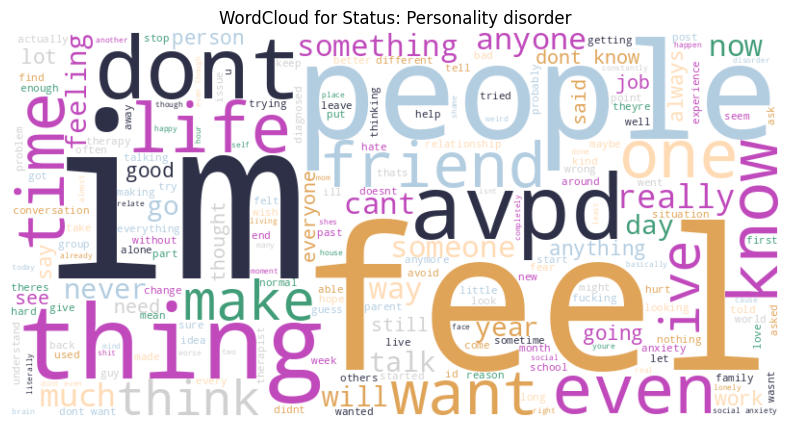

In [20]:
statuses = df['status'].unique()


def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)


for status in statuses:

    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)


    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [21]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [22]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])


X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [25]:
X_train_combined.shape

(42144, 50002)

In [26]:
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [27]:
X_train_resampled.shape


(91742, 50002)

In [28]:
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101),
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=0.5, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='gpu_hist')
}

In [29]:
!pip install --upgrade xgboost


In [30]:
import xgboost as xgb

clf = xgb.XGBClassifier(tree_method="hist", device='cpu')


In [31]:
print(clf.get_params())


{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 'cpu', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}




For Bernoulli Naive Bayes
Accuracy: 0.6405997912119199
                      precision    recall  f1-score   support

             Anxiety       0.66      0.60      0.63       768
             Bipolar       0.70      0.58      0.64       566
          Depression       0.66      0.48      0.55      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.86      0.34      0.49       202
              Stress       0.41      0.51      0.46       530
            Suicidal       0.59      0.54      0.56      2184

            accuracy                           0.64     10537
           macro avg       0.65      0.57      0.59     10537
        weighted avg       0.64      0.64      0.63     10537



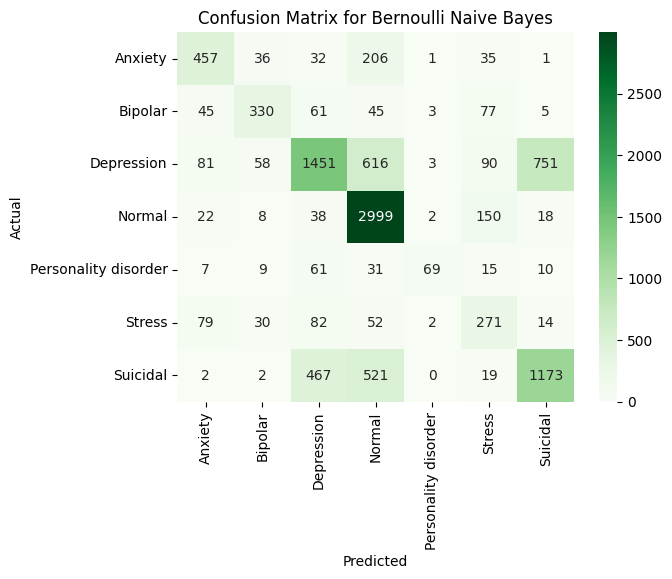



For Decision Tree
Accuracy: 0.6184872354560121
                      precision    recall  f1-score   support

             Anxiety       0.69      0.55      0.61       768
             Bipolar       0.45      0.64      0.52       566
          Depression       0.80      0.34      0.48      3050
              Normal       0.87      0.85      0.86      3237
Personality disorder       0.58      0.43      0.49       202
              Stress       0.24      0.80      0.37       530
            Suicidal       0.52      0.66      0.58      2184

            accuracy                           0.62     10537
           macro avg       0.59      0.61      0.56     10537
        weighted avg       0.70      0.62      0.62     10537



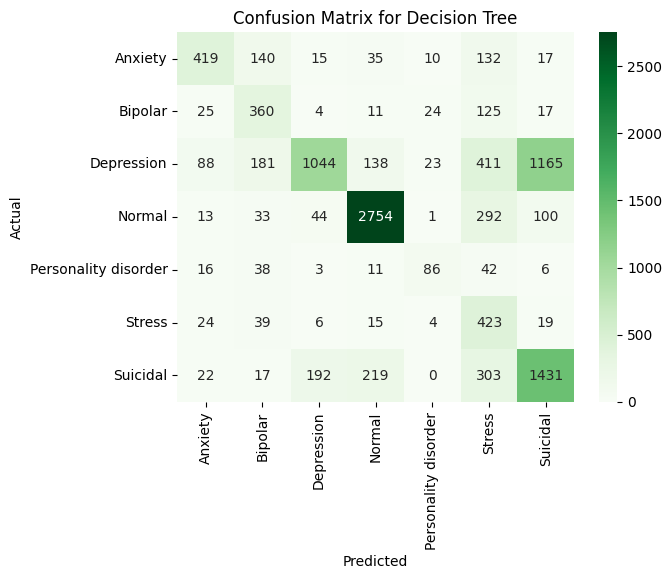



For Logistic Regression
Accuracy: 0.7657777355983677
                      precision    recall  f1-score   support

             Anxiety       0.75      0.83      0.78       768
             Bipolar       0.77      0.82      0.79       566
          Depression       0.83      0.59      0.69      3050
              Normal       0.89      0.91      0.90      3237
Personality disorder       0.50      0.76      0.60       202
              Stress       0.49      0.75      0.59       530
            Suicidal       0.68      0.77      0.72      2184

            accuracy                           0.77     10537
           macro avg       0.70      0.77      0.73     10537
        weighted avg       0.78      0.77      0.77     10537



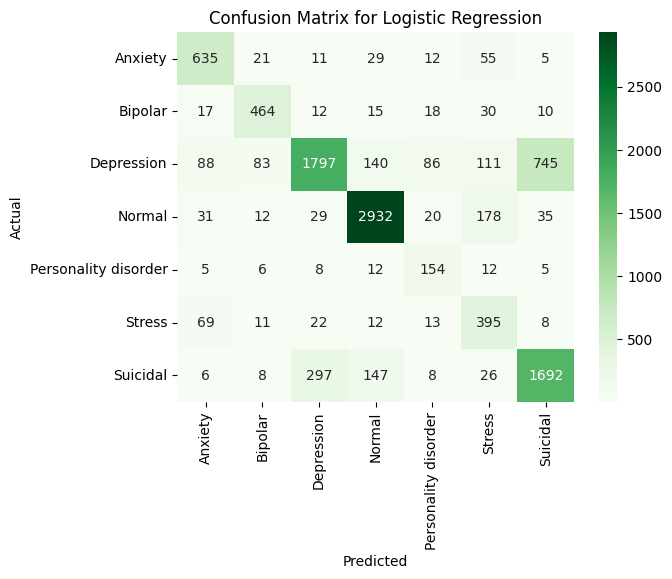



For XGB
Accuracy: 0.8080098699819683
                      precision    recall  f1-score   support

             Anxiety       0.83      0.86      0.85       768
             Bipolar       0.88      0.82      0.85       566
          Depression       0.78      0.73      0.75      3050
              Normal       0.92      0.93      0.93      3237
Personality disorder       0.84      0.65      0.74       202
              Stress       0.67      0.76      0.72       530
            Suicidal       0.69      0.73      0.71      2184

            accuracy                           0.81     10537
           macro avg       0.80      0.79      0.79     10537
        weighted avg       0.81      0.81      0.81     10537



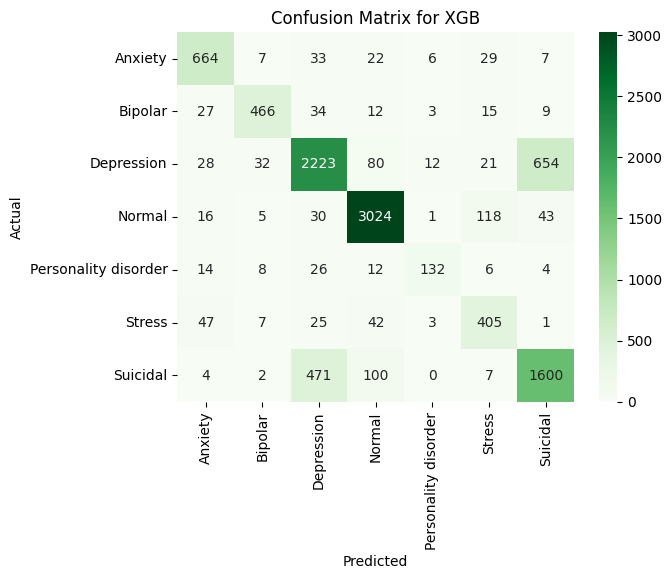

In [32]:
accuracy_scores = []


for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)

    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)


    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))


    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


    accuracy_scores.append(accuracy)

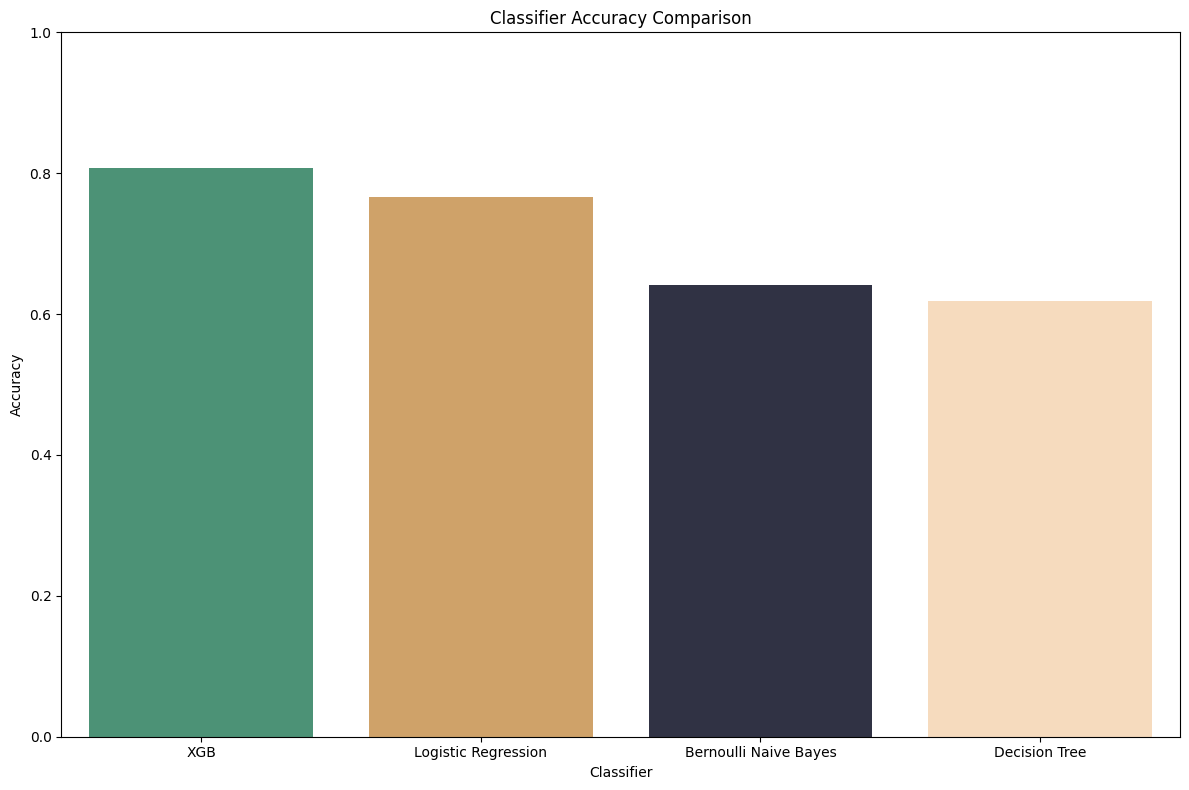

In [33]:
accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors[:4]))


sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In our project, we evaluated four models designed to handle large datasets with numerous features: Bernoulli Naive Bayes, Decision Tree, Logistic Regression.Logistic Regression emerged as the top performer with an accuracy of 81%. The classification report showed that the Normal state was the easiest to distinguish with an F1 score of 93, followed by Anxiety and Bipolar with F1 scores of 85. Other states also performed well, with F1 scores above 70. Although the Confusion Matrix and WordCloud analysis revealed some overlap between depression and suicidal messages,Logistic Regression still outperformed the other models and demonstrated superior overall performance.

In [39]:
def preprocess_new_sentence(sentence):
    sentence = sentence.lower()
    sentence = remove_patterns(sentence)
    tokens = word_tokenize(sentence)
    stemmed_tokens = stem_tokens(tokens)
    return stemmed_tokens


new_sentence = "I am depressed"

processed_sentence = preprocess_new_sentence(new_sentence)


new_sentence_tfidf = vectorizer.transform([processed_sentence])


num_chars = len(new_sentence)
num_sentences = len(nltk.sent_tokenize(new_sentence))

new_sentence_features = hstack([new_sentence_tfidf, np.array([num_chars, num_sentences])])

predicted_category_index = classifiers['Logistic Regression'].predict(new_sentence_features)[0]


predicted_category = lbl_enc.classes_[predicted_category_index]

print(f"The predicted category for the sentence is: {predicted_category}")

The predicted category for the sentence is: Depression


In [40]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00
